<a href="https://colab.research.google.com/github/Phavour-EBEN/Autoencoders/blob/main/Autoenoder_Implementation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, backend
from tensorflow.keras.layers import Input, ReLU, BatchNormalization, Flatten
from tensorflow import keras
import numpy as np
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
import os
import pickle

In [2]:
class Autoencoder:
  def __init__(self,input_shape, conv_filters, conv_kernel, conv_strides, latent_space_dim):
    self.input_shape = input_shape
    self.conv_filters = conv_filters
    self.conv_kernel = conv_kernel
    self.conv_strides = conv_strides
    self.latent_space_dim = latent_space_dim

    self.encoder = None
    self.decoder = None
    self.model = None
    self.shape_before_bottleneck = None
    self._model_input = None

    self._num_conv_layers = len(conv_filters)
    self._build()

  def summary(self):
    self.encoder.summary()
    self.decoder.summary()
    self.model.summary()

  def compile(self, learning_rate=0.001):
    optimizer = Adam(learning_rate=learning_rate)
    loss = MeanSquaredError()
    # metrics = Accuracy()
    self.model.compile(optimizer,loss)

  def train(self, x_train, batch_size, num_epochs):
    self.model.fit(x_train,
                   x_train,
                   batch_size,
                   num_epochs,
                   shuffle=True)

  def save(self, save_folder='.'):
    self._create_folder_if_not_exists(save_folder)
    self._save_parameters(save_folder)
    self._save_weights(save_folder)

  def load_weights(self, weights_path):
    self.model.load_weights(weights_path)

  def reconstruct(self, images):
    latent_representations = self.encoder.predict(images)
    reconstructed_images = self.decoder.predict(latent_representations)
    return reconstructed_images

  @classmethod
  def load(cls, save_folder='.'):
    parameters_path = os.path.join(save_folder, 'parameters.pkl')
    with open(parameters_path, 'rb') as f:
      parameters = pickle.load(f)
    autoencoder = Autoencoder(*parameters)
    weights_path = os.path.join(save_folder, 'weights.weights.h5')
    autoencoder.model.load_weights(weights_path)
    return autoencoder

  def _create_folder_if_not_exists(self, folder):
    if not os.path.exists(folder):
      os.makedirs(folder)

  def _save_parameters(self, save_folder):
    parameters = [self.input_shape,
                  self.conv_filters,
                  self.conv_kernel,
                  self.conv_strides,
                  self.latent_space_dim]

    saved_path = os.path.join(save_folder, 'parameters.pkl')
    with open(saved_path, 'wb') as f:
      pickle.dump(parameters, f)

  def _save_weights(self, save_folder):
    weights_path = os.path.join(save_folder, 'weights.weights.h5')
    self.model.save_weights(weights_path)

  def _build(self):
    self._build_encoder()
    self._build_decoder()
    self._build_autoencoder()

# buiding the encoder
  def _build_encoder(self):
    encoder_input = self._add_encoder_input()
    conv_layers = self._add_conv_layers(encoder_input)
    bottleneck = self._add_bottleneck(conv_layers)
    self._model_input = encoder_input
    self.encoder = keras.Model(encoder_input, bottleneck, name='encoder')

  def _add_encoder_input(self):
    return Input(shape=self.input_shape, name='encoder_input')

  def _add_conv_layers(self, encoder_input):
    x = encoder_input
    for layer_index in range(self._num_conv_layers):
      x = self._add_conv_layer(layer_index, x)
    return x


  def _add_conv_layer(self,layer_index, x):
    layer_number = layer_index + 1
    conv_layer = keras.layers.Conv2D(filters = self.conv_filters[layer_index],
                                     kernel_size = self.conv_kernel[layer_index],
                                     strides = self.conv_strides[layer_index],
                                     padding = 'same',
                                     name = f'encoder_conv_layer_{layer_number}')

    x = conv_layer(x)
    x = ReLU(name = f'encoder_relu_{layer_number}')(x)
    x = BatchNormalization(name = f'encoder_bn_{layer_number}')(x)
    return x

  def _add_bottleneck(self, x):
    self.shape_before_bottleneck = backend.int_shape(x)[1:]
    x = Flatten()(x)
    x = keras.layers.Dense(self.latent_space_dim, name= 'encoder_output')(x)
    return x



  # building the decoder
  def _build_decoder(self):
    decoder_input = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoder_input)
    reshape_layer = self._add_reshape_layer(dense_layer)
    conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
    decoder_output = self._add_decoder_output(conv_transpose_layers)
    self.decoder = keras.Model(decoder_input, decoder_output, name='decoder')

  def _add_decoder_input(self):
    return Input(shape=(self.latent_space_dim,), name='decoder_input')

  def _add_dense_layer(self, decoder_input):
    num_neurons = np.prod(self.shape_before_bottleneck)
    dense_layer = keras.layers.Dense(num_neurons, name='decoder_dense')(decoder_input)
    return dense_layer

  def _add_reshape_layer(self, dense_layer):
    return keras.layers.Reshape(self.shape_before_bottleneck)(dense_layer)

  def _add_conv_transpose_layers(self, x):
    for layer_index in reversed(range(1, self._num_conv_layers)):
      x = self._add_conv_transpose_layer(layer_index, x)
    return x


  def _add_conv_transpose_layer(self, layer_index,x):
    layer_num = self._num_conv_layers - layer_index
    conv_transpose_layer = keras.layers.Conv2DTranspose(filters=self.conv_filters[layer_index],
                                                        kernel_size=self.conv_kernel[layer_index],
                                                        strides =self.conv_strides[layer_index],
                                                        padding = 'same',
                                                        name = f'decoder_conv_transpose_layer_{layer_num}')
    x = conv_transpose_layer(x)
    x = ReLU(name=f'decoder_relu_{layer_num}')(x)
    x = BatchNormalization(name=f'decoder_bn_{layer_num}')(x)
    return x

  def _add_decoder_output(self, x):
    conv_transpose_layer = keras.layers.Conv2DTranspose(filters = 1,
                                                        kernel_size = self.conv_kernel[0],
                                                        strides = self.conv_strides[0],
                                                        padding = 'same',
                                                        name=f'decoder_conv_transpose_layer_{self._num_conv_layers}')
    x = conv_transpose_layer(x)
    output_layer = keras.layers.Activation('sigmoid', name='sigmoid_layer')(x)
    return output_layer

  def _build_autoencoder(self):
    model_input = self._model_input
    model_output = self.decoder(self.encoder(model_input))
    self.model = keras.Model(model_input, model_output, name='autoencoder')



if __name__ == '__main__':
  autoencoder = Autoencoder(
      input_shape = (28,28,1),
      conv_filters = (32,64,64,64),
      conv_kernel = (3,3,3,3),
      conv_strides = (1,2,2,1),
      latent_space_dim = 2
  )
autoencoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_1 (Conv2D)        │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_1 (ReLU)                │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_1 (BatchNormalization)    │ (None, 28, 28, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_2 (Conv2D)        │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_2 (ReLU)                │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_2 (BatchNormalization)    │ (None, 14, 14, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_3 (Conv2D)        │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_3 (ReLU)                │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_3 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_4 (Conv2D)        │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_4 (ReLU)                │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_4 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           6,274 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,842 (390.01 KB)

 Trainable params: 99,394 (388.26 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense (Dense)                │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_1       │ (None, 7, 7, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_1 (ReLU)                │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_1 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_2       │ (None, 14, 14, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_2 (ReLU)                │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_2 (BatchNormalization)    │ (None, 14, 14, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_3       │ (None, 28, 28, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_3 (ReLU)                │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_3 (BatchNormalization)    │ (None, 28, 28, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_4       │ (None, 28, 28, 1)           │             577 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sigmoid_layer (Activation)           │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,537 (474.75 KB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 384 (1.50 KB)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 2)                   │          99,842 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         121,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,379 (864.76 KB)

 Trainable params: 220,547 (861.51 KB)

 Non-trainable params: 832 (3.25 KB)

In [3]:
# from autoencoder import Autoencoder
from tensorflow.keras.datasets import mnist
import numpy as np
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 20


def load_mnist():
  (x_train, y_train),(x_test, y_test) = mnist.load_data()

  x_train = x_train.astype('float32')/225.
  x_train = x_train.reshape(x_train.shape + (1,))
  x_test = x_test.astype('float32')/225.
  x_test = x_test.reshape(x_test.shape + (1,))
  return x_train, y_train, x_test, y_test

def train(x_train, learning_rate, batch_size, num_epochs):
  autoencoder = Autoencoder(
      input_shape = (28,28,1),
      conv_filters = (32,64,64,64),
      conv_kernel = (3,3,3,3),
      conv_strides = (1,2,2,1),
      latent_space_dim = 2
  )
  autoencoder.summary()
  autoencoder.compile(learning_rate)
  autoencoder.train(x_train, batch_size, num_epochs)
  return autoencoder

if __name__ == "__main__":
  x_train, _, _, _ = load_mnist()
  autoencoder = train(x_train[:20000], LEARNING_RATE, BATCH_SIZE, NUM_EPOCHS)
  autoencoder.save('model')
  autoencoder2 = Autoencoder.load('model')
  autoencoder2.summary()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_1 (Conv2D)        │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_1 (ReLU)                │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_1 (BatchNormalization)    │ (None, 28, 28, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_2 (Conv2D)        │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_2 (ReLU)                │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_2 (BatchNormalization)    │ (None, 14, 14, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_3 (Conv2D)        │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_3 (ReLU)                │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_3 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_4 (Conv2D)        │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_4 (ReLU)                │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_4 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           6,274 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,842 (390.01 KB)

 Trainable params: 99,394 (388.26 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense (Dense)                │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_1       │ (None, 7, 7, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_1 (ReLU)                │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_1 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_2       │ (None, 14, 14, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_2 (ReLU)                │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_2 (BatchNormalization)    │ (None, 14, 14, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_3       │ (None, 28, 28, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_3 (ReLU)                │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_3 (BatchNormalization)    │ (None, 28, 28, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_4       │ (None, 28, 28, 1)           │             577 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sigmoid_layer (Activation)           │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,537 (474.75 KB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 384 (1.50 KB)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 2)                   │          99,842 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         121,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,379 (864.76 KB)

 Trainable params: 220,547 (861.51 KB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.1025
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0662
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0611
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0585
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0569
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0553
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0548
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0538
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0531
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0522
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0522
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0517
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0509
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0508
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - l

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_1 (Conv2D)        │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_1 (ReLU)                │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_1 (BatchNormalization)    │ (None, 28, 28, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_2 (Conv2D)        │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_2 (ReLU)                │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_2 (BatchNormalization)    │ (None, 14, 14, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_3 (Conv2D)        │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_3 (ReLU)                │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_3 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_4 (Conv2D)        │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_4 (ReLU)                │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_4 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           6,274 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,842 (390.01 KB)

 Trainable params: 99,394 (388.26 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense (Dense)                │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_1       │ (None, 7, 7, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_1 (ReLU)                │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_1 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_2       │ (None, 14, 14, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_2 (ReLU)                │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_2 (BatchNormalization)    │ (None, 14, 14, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_3       │ (None, 28, 28, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_3 (ReLU)                │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_3 (BatchNormalization)    │ (None, 28, 28, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_4       │ (None, 28, 28, 1)           │             577 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sigmoid_layer (Activation)           │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,537 (474.75 KB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 384 (1.50 KB)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 2)                   │          99,842 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         121,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,379 (864.76 KB)

 Trainable params: 220,547 (861.51 KB)

 Non-trainable params: 832 (3.25 KB)

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import numpy as np


def select_image(images, labels, num_images=10):
  sample_indices = np.random.choice(range(len(images)), num_images)
  sample_images = images[sample_indices]
  sample_labels = labels[sample_indices]
  return sample_images, sample_labels

def plot_reconstructed_images(images,reconstructed_images):
  fig = plt.figure(figsize=(15,3))
  num_images = len(images)

  for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
    image = image.squeeze()
    ax = fig.add_subplot(2, num_images, i+1)
    ax.axis('off')
    ax.imshow(image, cmap='gray_r')
    reconstructed_image = reconstructed_image.squeeze()
    ax = fig.add_subplot(2, num_images, i+num_images+1)
    ax.axis('off')
    ax.imshow(reconstructed_image, cmap='gray_r')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


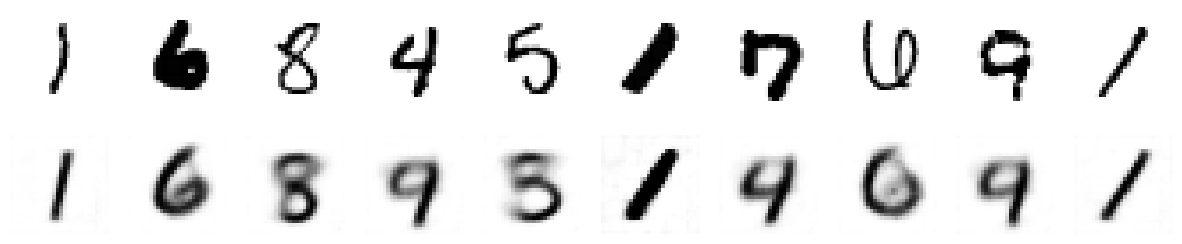

In [5]:
x_train, y_train, x_test, y_test = load_mnist()
images, labels = select_image(x_test, y_test, num_images=10)
reconstructed_images = autoencoder.reconstruct(images)
plot_reconstructed_images(images, reconstructed_images)

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


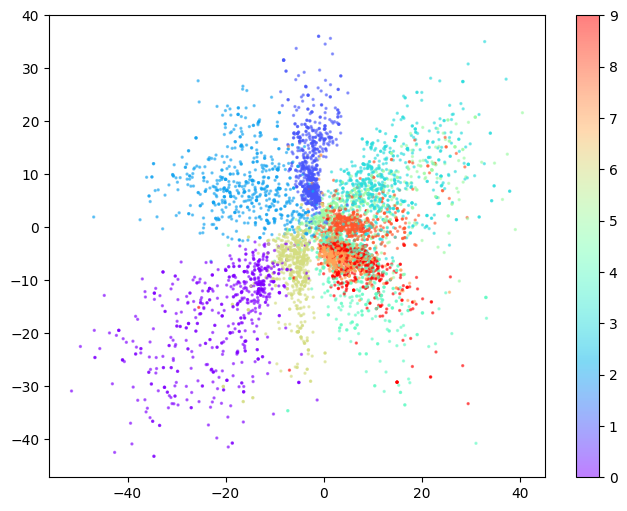

In [6]:
# visualizing the buttomneck
def plot_latent_space(latent_representations, labels):
  latent_representations = autoencoder.encoder.predict(images)
  plt.figure(figsize=(8,6))
  plt.scatter(latent_representations[:,0],
              latent_representations[:,1],
              cmap='rainbow',
              alpha=0.5,
              s=2,
              c=labels)
  plt.colorbar()
  plt.show()


x_train, y_train, x_test, y_test = load_mnist()
images, labels = select_image(x_test, y_test, num_images=6000)
latent_representations = autoencoder.encoder.predict(images)
plot_latent_space(latent_representations, labels)